In [1]:
# import all packages

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor


In [2]:
### original dataset visualization

def show_orgi_data(dataset_name):   
    # load data
    data = pd.read_csv(dataset_name, header=0, parse_dates=[0], index_col=0, squeeze=True)
    
#     # show original data
#     groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#     i = 1
#     # plot each column
#     plt.figure(figsize=(15,20))
#     for group in groups:
#         plt.subplot(len(groups), 1, i)
#         plt.plot(data.values[:, group])
#         plt.title(data.columns[group], y=0.5, loc='right')
#         i += 1
#     plt.tight_layout()
#     data.info()
    
    return data

In [3]:
### data pre-processing

def pre_processing(data):
    # check nonnull
    data = data.fillna(data.mean())
    
    # split the data to end up with the following dataframes: X_train,X_test,y_train, y_test   
    X = data.drop(columns=['date','NO2-2020','COVID-19 increased cases','COVID-19 increased deaths','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
    y = data['NO2-2020']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)
    
    # standardscaler
    xscaler = StandardScaler()
    yscaler = StandardScaler()
    X_train_scaled = xscaler.fit_transform(X_train)
    X_test_scaled = xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_scaled = yscaler.transform(y_test.values.reshape(-1,1))
    
#     # perform a boxplot of X_train_scaled here
#     ax = sns.boxplot(data=X_train)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
#     ax.set_title("original data distribution")
#     plt.show()
    
#     ax = sns.boxplot(data=X_train_scaled)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
#     ax.set_title("pre_processing data distribution")
#     plt.show()
   
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, yscaler,xscaler

In [4]:
### plot observed data and predicted data
def plot_residual(model, X_train, X_test, y_train, y_test, yscaler):
    
    #get_ipython().run_line_magic('matplotlib', 'inline')
    
#     st.markdown("## Observed Data and Predicted Data")
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y_train,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y_train,y_pred_train))
    print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    y_test = yscaler.inverse_transform(y_test)
    y_pred_test = yscaler.inverse_transform(y_pred_test)
    
    minlim = y_test.min()
    maxlim = y_test.max()
    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_test,y=y_pred_test, height=5,xlim=(minlim,maxlim),ylim=(minlim,maxlim))
    ax.ax_joint.set_xlabel('observed NO2 reduction')
    ax.ax_joint.set_ylabel('predicted NO2 reduction')
#     st.pyplot()
    plt.figure()
    sns.distplot(y_test-y_pred_test)
    plt.xlabel('Residuals')
    plt.show()
#     st.pyplot()

In [5]:
def rf_model(X_train, X_test, y_train, y_test):
    sc = StandardScaler()
    rfr = RandomForestRegressor(n_estimators=1000,max_features=1,min_samples_split=6)
    pipe = Pipeline([('scaler',sc),('forest', rfr)])
    model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())
    model.fit(X_train, y_train)
    return model



In [6]:
def main():   
    dataset_name = 'AMI_Data.csv'
    data = show_orgi_data(dataset_name)
  
    ### Pipeline: 2. data pre-processing
    X_train, X_test, y_train, y_test, yscaler, xscaler = pre_processing(data)
    
    ### Pipeline: 3. model selection

    model = rf_model(X_train, X_test, y_train, y_test)
    # plot_residual(model, X_train, X_test, y_train, y_test, yscaler)
    return data, model,xscaler,yscaler

In [7]:
def choose_date(date,data): 
    data_red = data.drop(columns=['NO2-2020','COVID-19 increased cases','COVID-19 increased deaths','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'])
    index = data_red[data_red.date ==date].index.tolist()
    data_red = data_red.loc[index].values.reshape(-1,1)
    
    f_h=data_red[1][0]
    f_b=data_red[2][0]
    f_g=data_red[3][0]
    bio=data_red[4][0]
    no2=data_red[5][0]
    policy=data_red[6][0]
    x_date = np.array([[f_h,f_b,f_g,bio,no2,policy]])
    return x_date





In [8]:
def x_input(f_h,f_b,f_g,bio,no2,policy):
    x_date = np.array([[f_h,f_b,f_g,bio,no2,policy]])
    return x_date

In [46]:
def plot_policy_prediction(x_date):
    factor = np.linspace(0, 77, 100)
    stringency = x_date[0][5]
    x_scale = xscaler.transform(x_date)    
    y_temp = model.predict(x_scale) 
    y_st=yscaler.inverse_transform(y_temp)
    
    y_pre =np.empty([100,1])
    i=0
    for item in factor:
        x_date[0][5] = item
        x_scale = xscaler.transform(x_date)    
        y_temp = model.predict(x_scale) 
        y_temp=yscaler.inverse_transform(y_temp)
        y_pre[i]=y_temp
        i=i+1

    plt.figure(figsize=(20,10))
    plt.plot(factor,y_pre)
    plt.xlabel('covid policy stringency',fontsize=20)
    plt.ylabel('predicted NO2_2020',fontsize=20)
    plt.xticks(np.arange(min(factor), max(factor), 1),rotation=70,fontsize=12)
    plt.yticks(np.arange(min(y_pre), max(y_pre), 0.25),fontsize=12)
    plt.scatter(stringency,y_st)
    plt.text(stringency,y_st,[stringency,y_st[0][0]])
    plt.grid()
    plt.show()
    
    print('the predicted NO2_2020 emission under original policy stringency',y_st)

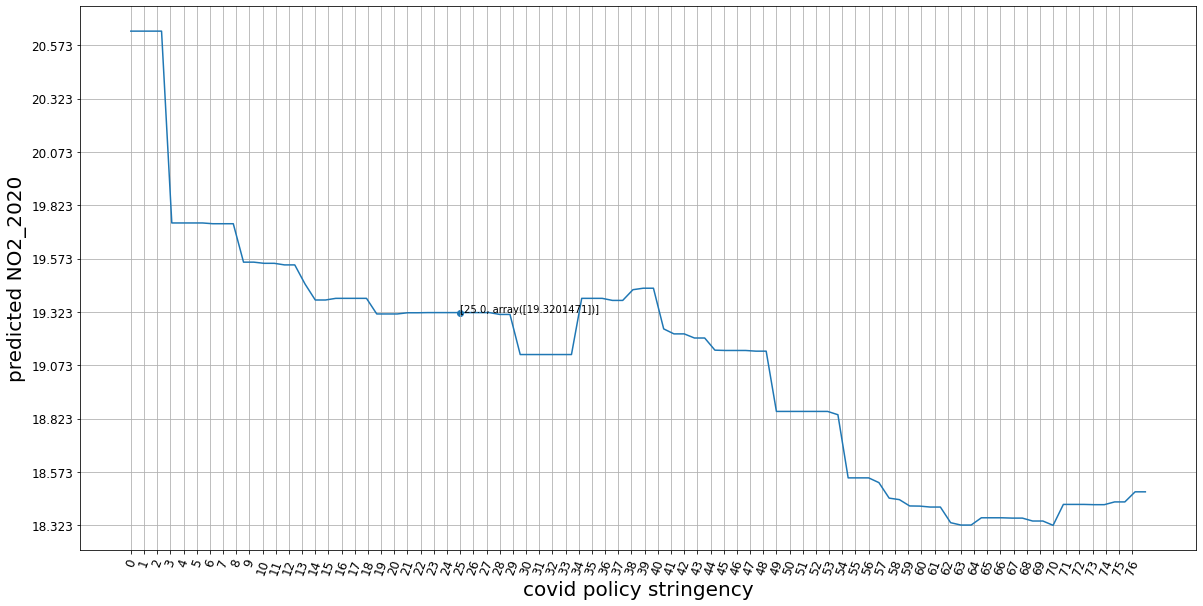

the predicted NO2_2020 emission under original policy stringency [[19.3201471]]


In [47]:
data, model,xscaler,yscaler=main()
## if you want to observe the variation of the old data when only change the policy stringency,for example, on 2020-08-03
date = '2020-03-03'
x_date=choose_date(date,data)
plot_policy_prediction(x_date)

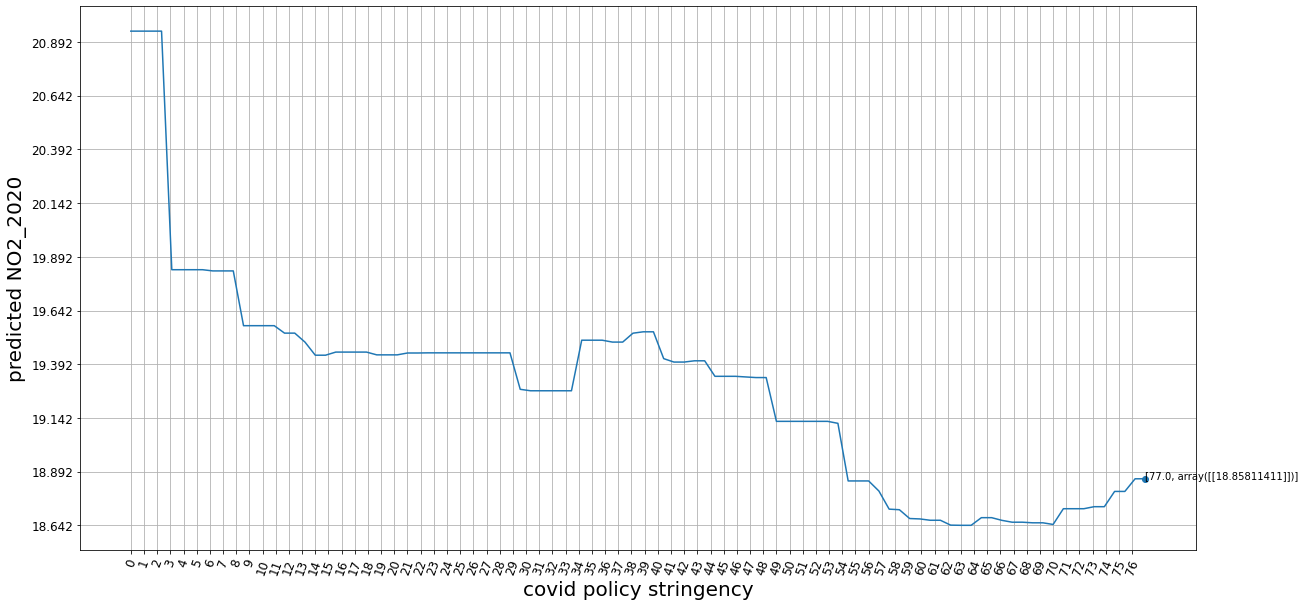

the predicted NO2_2020 emission under original policy stringency [[18.85811411]]


In [44]:
plot_policy_prediction(x_date)

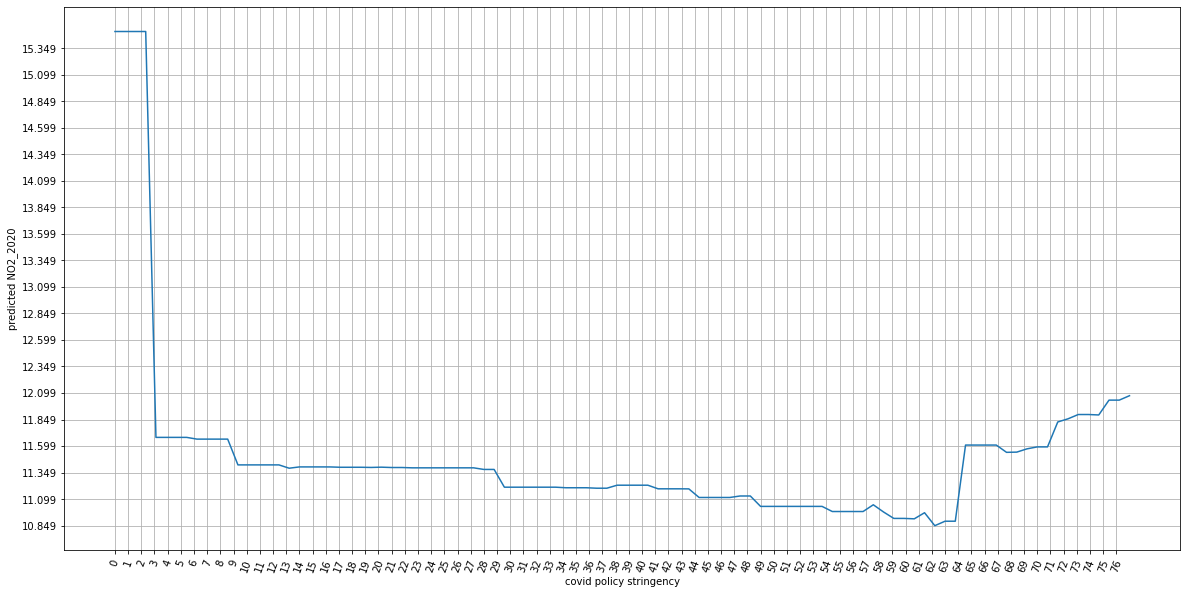

In [25]:
## if you collect new data, you can also manually input and observe the variation when only change the policy stringency
## but notice the reasonability of the new data
x_date=x_input(45000,27000,200000,100000,13,46)
plot_policy_prediction(x_date)